In [5]:
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')


NameError: name 'warnings' is not defined

# 1.Load the dataset and explore the variables.

In [6]:
data = pd.read_csv(r'C:\Users\parag\Desktop\ironhack\lab\week8\lab-imbalanced-data\files_for_lab\customer_churn.csv') # this file is in files_for_lesson_and_activities folder
data#.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [7]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [14]:
cols = []

for i in range(len(data.columns)):
    cols.append(data.columns[i].lower().replace(" ","_"))
    
data.columns = cols

In [15]:
data.shape

(7043, 21)

In [16]:
data.describe()

,seniorcitizen,tenure,monthlycharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# 2. We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen,MonthlyCharges.

In [17]:
#data did not have  null value 
nulls = pd.DataFrame(data.isna().sum()*100/len(data), columns=['percentage'])
nulls.sort_values('percentage', ascending = False)

,percentage
customerid,0.0
deviceprotection,0.0
totalcharges,0.0
monthlycharges,0.0
paymentmethod,0.0
paperlessbilling,0.0
contract,0.0
streamingmovies,0.0
streamingtv,0.0
techsupport,0.0


# EDA

# 3. Extract the target variable.

In [9]:
data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [18]:
#Extract the target variable
target = data['churn']

#Extract the independent variables and scale them.
ind_vars = data[['tenure','seniorcitizen','monthlycharges']]

In [20]:
target = target.apply(lambda x: str(x).replace('Yes', '1').replace('No', '0')).astype(int)

# 4.Extract the independent variables and scale them

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ind_vars[['tenure','seniorcitizen','monthlycharges']] = scaler.fit_transform(ind_vars[['tenure','seniorcitizen','monthlycharges']])

ind_vars

C:\Users\parag\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,tenure,seniorcitizen,monthlycharges
0,0.013889,0.0,0.115423
1,0.472222,0.0,0.385075
2,0.027778,0.0,0.354229
3,0.625000,0.0,0.239303
4,0.027778,0.0,0.521891
...,...,...,...
7038,0.333333,0.0,0.662189
7039,1.000000,0.0,0.845274
7040,0.152778,0.0,0.112935
7041,0.055556,1.0,0.558706


In [22]:
df = pd.concat([target, ind_vars], axis=1)

In [23]:
df01 = df.copy()

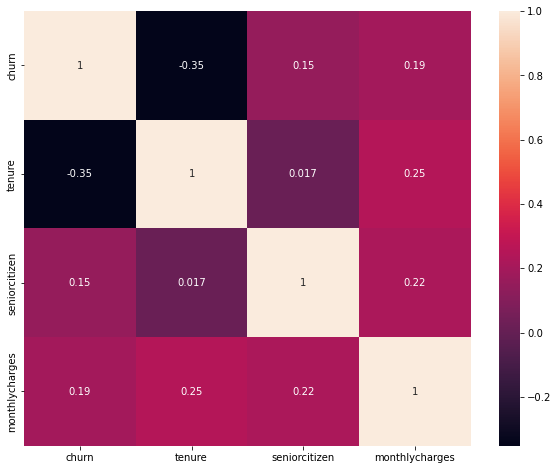

In [24]:
corr_matrix=df.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

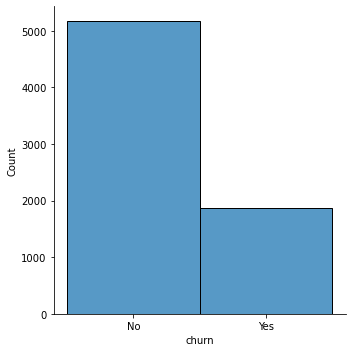

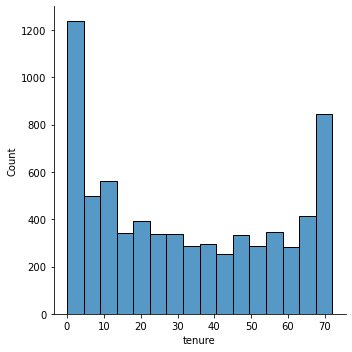

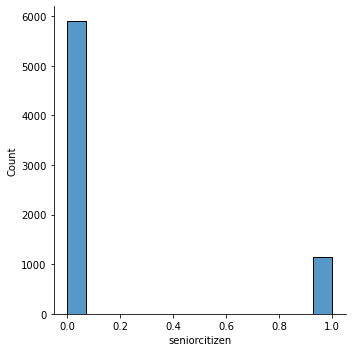

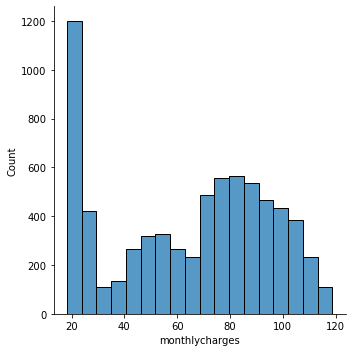

In [25]:
for col in df:
    sns.displot(data[col])
    plt.show()

### Prediction after using normalizer

# Synthetic Minority Oversampling TEchnique (SMOTE)

In [28]:
from imblearn.over_sampling import SMOTE

In [29]:
smote = SMOTE()


X = df01.drop('churn', axis=1)
y = df01['churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_sm, y_sm = smote.fit_resample(X_train,y_train)

y_sm.value_counts()

0    4138
1    4138
Name: churn, dtype: int64


# 5.Build the logisticregression  model.


In [30]:
classification = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=500) # max_iter #multiclass multinomial é o problema
classification.fit(X_sm, y_sm)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1036
           1       0.51      0.77      0.61       373

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409



# 6.Evaluate the model.

In [31]:
#Evaluate the model.
classification.score(X_test, y_test)


0.7444996451383961

In [32]:
confusion_matrix(y_test, predictions)

array([[762, 274],
       [ 86, 287]], dtype=int64)

<AxesSubplot:>

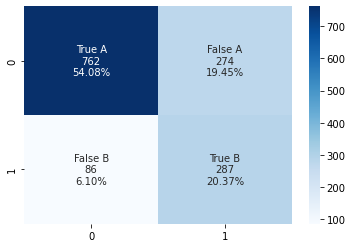

In [33]:
cf_matrix = confusion_matrix(y_test, predictions)
y_true = y_test
y_pred = predictions
confusion_matrix(y_true, y_pred)

group_names = ['True A', 'False A', 'False B', 'True B']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [34]:
from sklearn import metrics

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1036
           1       0.51      0.77      0.61       373

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409



In [40]:
#9.Build and evaluate the logistic regression model. Is it there any improvement?

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import TomekLinks 


tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train,y_train)

classification.fit(X_res,y_res)
predictions = classification.predict(X_test)

In [41]:
confusion_matrix(y_test, predictions)

array([[914, 122],
       [168, 205]], dtype=int64)

<AxesSubplot:>

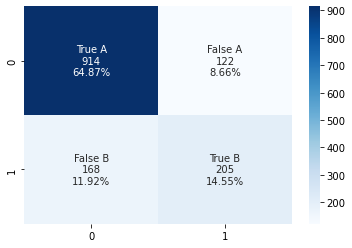

In [42]:
cf_matrix = confusion_matrix(y_test, predictions)
y_true = y_test
y_pred = predictions
confusion_matrix(y_true, y_pred)

group_names = ['True A', 'False A', 'False B', 'True B']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [39]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1036
           1       0.63      0.55      0.59       373

    accuracy                           0.79      1409
   macro avg       0.74      0.72      0.72      1409
weighted avg       0.79      0.79      0.79      1409

